In [ ]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(
    "applestock.csv",
    parse_dates = ['Date'],
    usecols = ['Date', 'Open']
)

In [3]:
data

,Date,Open
0,2016-05-16,92.389999
1,2016-05-13,90.000000
2,2016-05-12,92.720001
3,2016-05-11,93.480003
4,2016-05-10,93.330002
...,...,...
8928,1980-12-18,26.625000
8929,1980-12-17,25.875000
8930,1980-12-16,25.375000
8931,1980-12-15,27.375001


# **Предобработка данных**

### Заполнение пропусков

In [4]:
data_ts = data.rename(columns={'Date': 'timestamp', 'Open': 'target'})
data_ts['segment'] = 'segment'
data_ts.head()

,timestamp,target,segment
0,2016-05-16,92.389999,segment
1,2016-05-13,90.000000,segment
2,2016-05-12,92.720001,segment
3,2016-05-11,93.480003,segment
4,2016-05-10,93.330002,segment


In [5]:
data_ts = TSDataset.to_dataset(data_ts)
data_ts.head()

segment,segment
feature,target
timestamp,
1980-12-12,28.750000
1980-12-15,27.375001
1980-12-16,25.375000
1980-12-17,25.875000
1980-12-18,26.625000


<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
segment       1980-12-12    2016-05-16   12940         4007


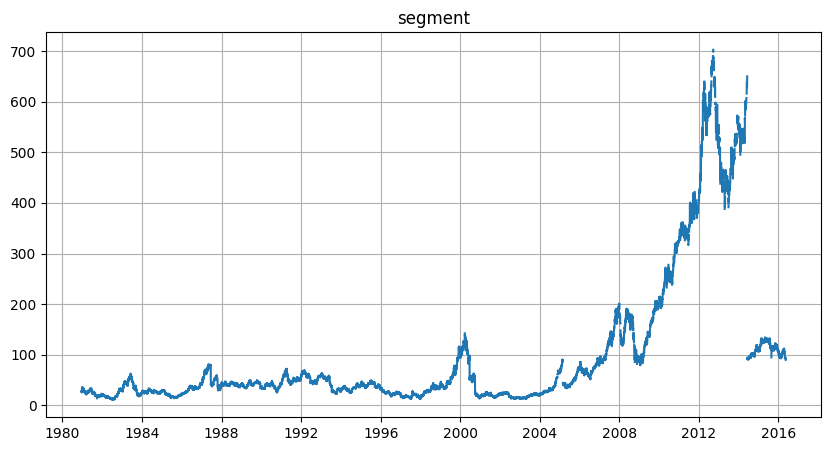

In [6]:
data_ts = TSDataset(data_ts, freq="D")
data_ts.plot()
data_ts.info()

In [7]:
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis import plot_imputation

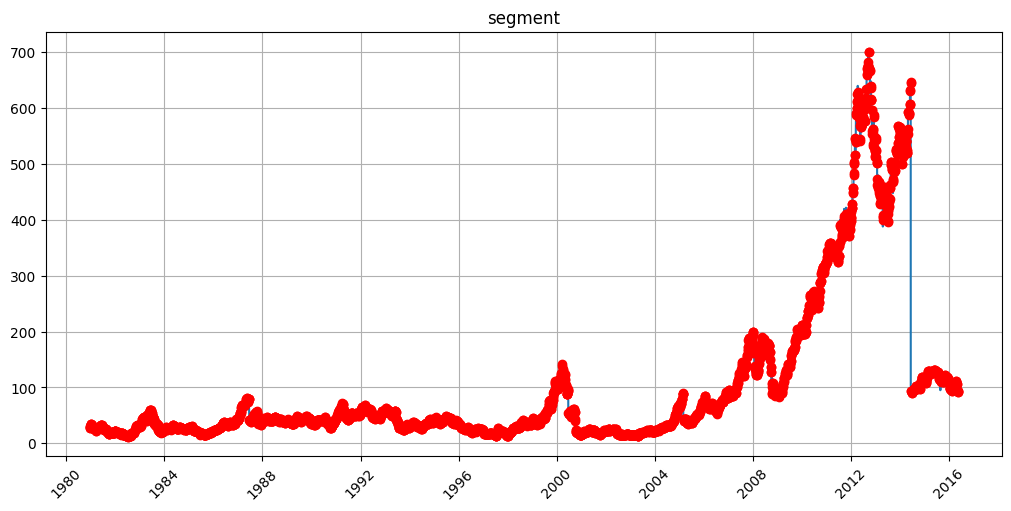

In [8]:
imputer = TimeSeriesImputerTransform(
    in_column='target',
    strategy='running_mean',
    window=3
)

plot_imputation(ts=data_ts, imputer=imputer)

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
segment       1980-12-12    2016-05-16   12940            0


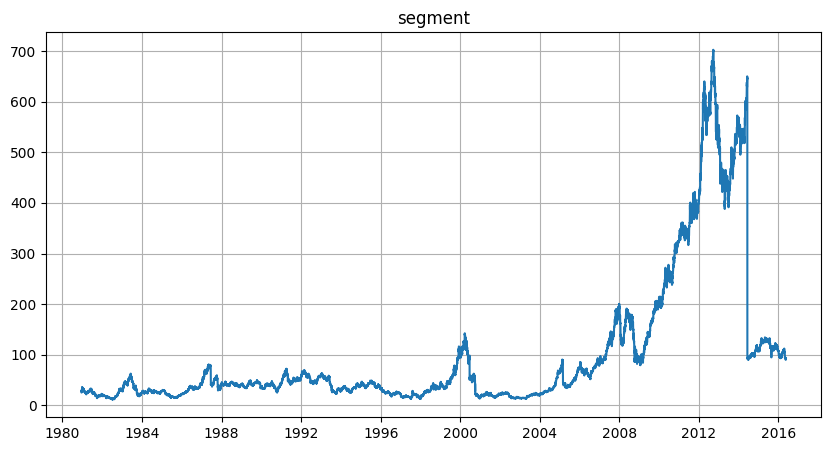

In [9]:
data_ts.fit_transform([imputer])
data_ts.plot()
data_ts.info()

In [10]:
data_df = data_ts.to_pandas(flatten=True)[['timestamp', 'target']].set_index('timestamp')
data_ts = TSDataset(data_ts.to_pandas(flatten=True), freq='D')

### Обработка выбросов

In [11]:
from etna.analysis import plot_anomalies
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density, get_anomalies_hist

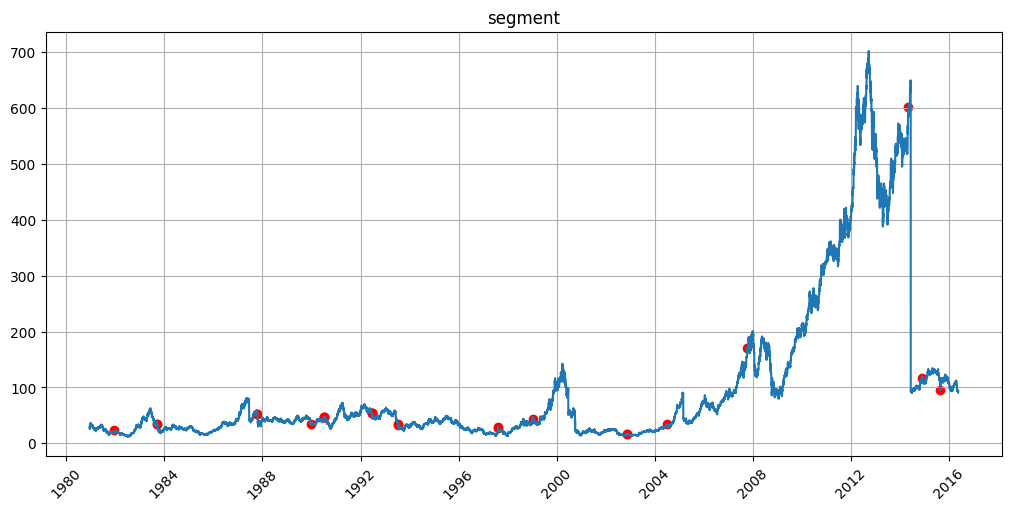

In [12]:
anomaly_dict = get_anomalies_median(data_ts, window_size = 100)
plot_anomalies(data_ts, anomaly_dict)

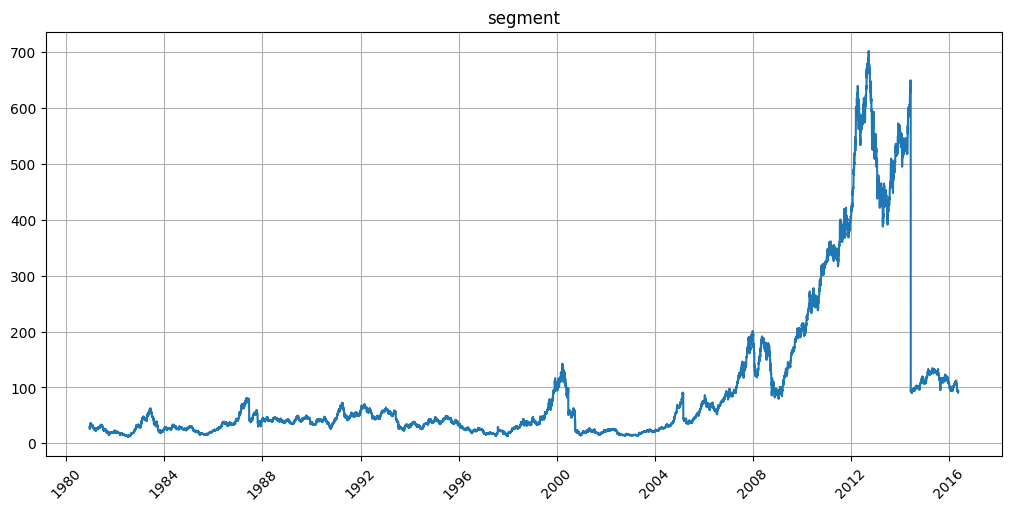

In [13]:
anomaly_dict = get_anomalies_density(
    data_ts,
    window_size = 25,
    distance_coef = 2,
    n_neighbors = 4
)
plot_anomalies(data_ts, anomaly_dict)

Т.к. рассматриваемые данные связаны с ценами на акции, то все возможные выбросы скорее всего связаны с ценной информацией, повлиявшей на стоимость. Поэтому в данном случае нет смысла преобразовывать выбросы.

# **Анализ структуры временного ряда**

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from etna.analysis import plot_forecast

In [16]:
adfuller(data_df['target'])

(-2.180673664548259,
 0.21333442072261527,
 13,
 12926,
 {'1%': -3.430856003334237,
  '5%': -2.8617636289491344,
  '10%': -2.5668890327490286},
 81853.61808389216)

(-2.180673664548259, 0.21333442072261527, 13, 12926, {'1%': -3.430856003334237, '5%': -2.8617636289491344, '10%': -2.5668890327490286}, 81853.61808389216)


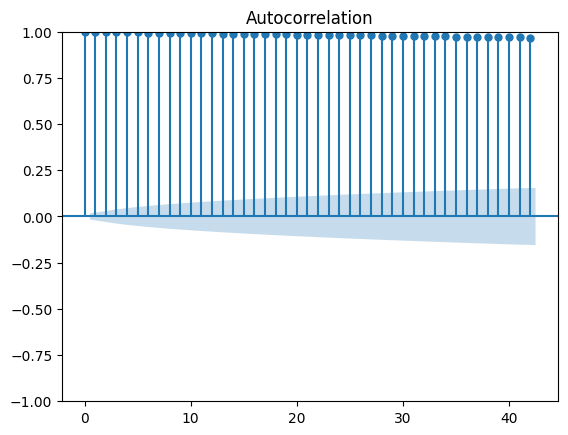

In [160]:
print(adfuller(data_df['target']))
plot_acf(data_df['target']);

Исходя из результатов теста Дики-Фуллера, можно сказать что ряд нестационарен. Значение ADF-статистики больше критических значений, что не дает нам отвергнуть нулевую гипотезу о нестационарности временного ряда. P-значение(0,2427...) также не дает нам отвергнуть нулевую гипотезу, поскольку превышает общепринятый установленный порог в 0.05.

In [161]:
from scipy import stats

In [162]:
data_df['diff'] = data_df['target'] - data_df['target'].shift(1)

In [163]:
data_df

,target,diff
timestamp,,
1980-12-12,28.750000,NaN
1980-12-13,28.750000,0.000000
1980-12-14,28.750000,0.000000
1980-12-15,27.375001,-1.374999
1980-12-16,25.375000,-2.000001
...,...,...
2016-05-12,92.720001,-0.760002
2016-05-13,90.000000,-2.720001
2016-05-14,92.066668,2.066668


In [164]:
adfuller(data_df['diff'][1:])

(-33.05238404914034,
 0.0,
 12,
 12926,
 {'1%': -3.430856003334237,
  '5%': -2.8617636289491344,
  '10%': -2.5668890327490286},
 81851.01978474887)

(-0.1, 0.1)

<Figure size 1200x800 with 0 Axes>

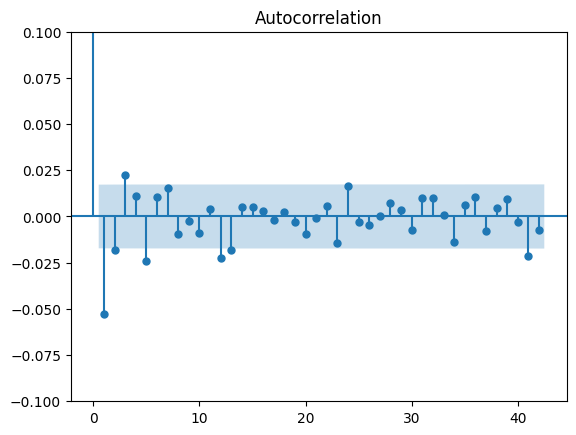

In [165]:
plt.figure(figsize=(12, 8))
plot_acf(data_df['diff'][1:]);
plt.ylim([-0.1, 0.1])

При помощи дифференцирования и проверки по критерия Дики-Фуллера, теперь можно отвергнуть нулевую гипотезу о нестационарности временного ряда. По графику видно, что у нас нет сезонной компоненты в ряде, поэтому мы можем не применять сезонное дифференциирование

# **Построение базовых (baseline) моделей**

## **Модель наивного прогноза**

In [166]:
# модель наивного прогноза, модель скользящего среднего, модель сезонного скользящего среднего
from etna.pipeline import Pipeline
HORIZON = 7

train_ts, test_ts = data_ts.train_test_split(test_size=HORIZON)

In [167]:
from etna.models import NaiveModel

In [168]:
model = NaiveModel(lag=10)
model.fit(train_ts)

NaiveModel(lag = 10, )

In [169]:
future_ts = train_ts.make_future(HORIZON, transforms=[imputer], tail_steps=model.context_size)
future_ts

segment,segment
feature,target
timestamp,
2016-04-30,95.866666
2016-05-01,95.822222
2016-05-02,93.970001
2016-05-03,94.199997
2016-05-04,95.199997
2016-05-05,94.000000
2016-05-06,93.370003
2016-05-07,94.190000


In [170]:
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,segment
feature,target
timestamp,
2016-05-10,95.866666
2016-05-11,95.822222
2016-05-12,93.970001
2016-05-13,94.199997
2016-05-14,95.199997
2016-05-15,94.000000
2016-05-16,93.370003


In [171]:
from etna.metrics import SMAPE

smape = SMAPE()

In [172]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment': 2.5782908871841457}

In [173]:
model_results = {}

In [174]:
model_results['NaiveModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

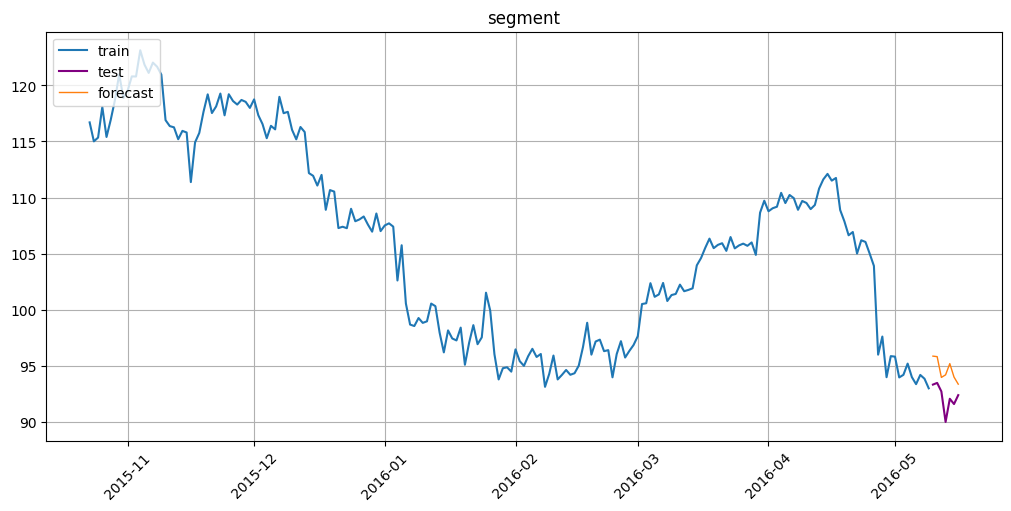

In [175]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=200)

## **Модель скользящего среднего**

In [176]:
from etna.models import MovingAverageModel

In [177]:
MAM = MovingAverageModel(window=10)

MAM.fit(train_ts)

future_ts = train_ts.make_future(HORIZON, tail_steps=MAM.context_size)
future_ts

segment,segment
feature,target
timestamp,
2016-04-30,95.866666
2016-05-01,95.822222
2016-05-02,93.970001
2016-05-03,94.199997
2016-05-04,95.199997
2016-05-05,94.000000
2016-05-06,93.370003
2016-05-07,94.190000


In [178]:
forecast_ts = MAM.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,segment
feature,target
timestamp,
2016-05-10,94.347222
2016-05-11,94.195278
2016-05-12,94.032583
2016-05-13,94.038841
2016-05-14,94.022726
2016-05-15,93.904999
2016-05-16,93.895499


In [179]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment': 1.9785196559403435}

In [180]:
model_results['MovingAverageModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

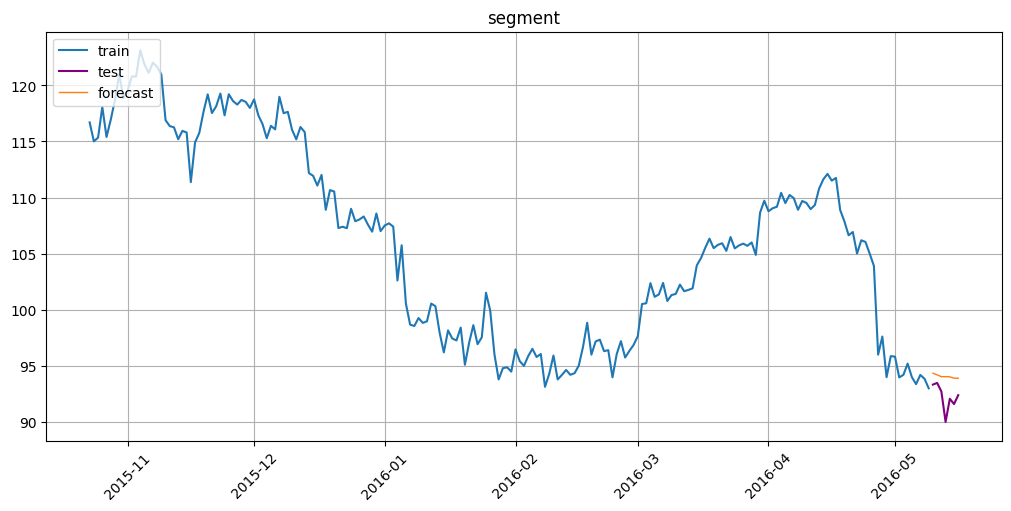

In [181]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=200)

## **Модель сезонного скользящего среднего**

In [182]:
from etna.models import SeasonalMovingAverageModel

In [183]:
SMAM = SeasonalMovingAverageModel(window=7, seasonality=1)
SMAM.fit(train_ts)

future_ts = train_ts.make_future(HORIZON, tail_steps=SMAM.context_size)
future_ts

segment,segment
feature,target
timestamp,
2016-05-03,94.199997
2016-05-04,95.199997
2016-05-05,94.000000
2016-05-06,93.370003
2016-05-07,94.190000
2016-05-08,93.853334
2016-05-09,93.000000
2016-05-10,NaN


In [184]:
forecast_ts = SMAM.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,segment
feature,target
timestamp,
2016-05-10,93.973333
2016-05-11,93.940952
2016-05-12,93.761089
2016-05-13,93.726959
2016-05-14,93.777953
2016-05-15,93.719089
2016-05-16,93.699911


In [185]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment': 1.6991028235925834}

In [186]:
model_results['SeasonalMovingAverageModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

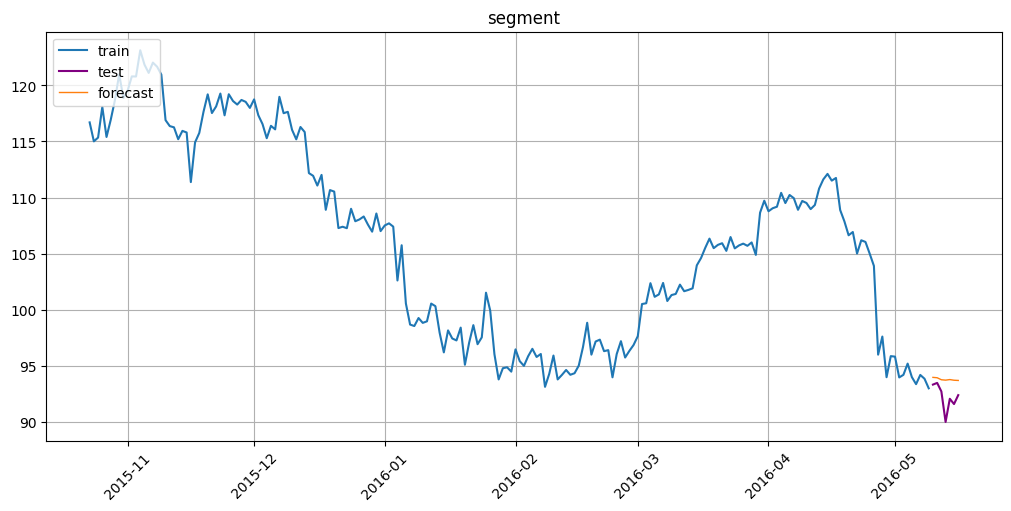

In [187]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=200)

# **Построение ETS моделей**

In [188]:
# модель экспоненциального среднего, модель Хольта, модель Хольта-Винтерса
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [189]:
dict_params = {}

In [190]:
fit_SES = SimpleExpSmoothing(
    data_df['target'], 
    initialization_method='estimated'
).fit()

In [191]:
fit_SES.model.params

{'smoothing_level': 0.945362581172402,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 28.749755438946675,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [192]:
alpha_SES = fit_SES.model.params['smoothing_level']
print(alpha_SES)
dict_params['ses'] = [alpha_SES]

0.945362581172402


In [193]:
fit_H = Holt(
    data_df['target'], 
    initialization_method='estimated'
).fit()

In [194]:
fit_H.model.params

{'smoothing_level': 0.9477686996725518,
 'smoothing_trend': 9.99806700771378e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 28.408421623958315,
 'initial_trend': 0.010532859785354565,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [195]:
alpha_H = fit_H.model.params['smoothing_level']
beta_H = fit_H.model.params['smoothing_trend']
print(alpha_H, beta_H)
dict_params['H'] = [alpha_H, beta_H]

0.9477686996725518 9.99806700771378e-05


In [196]:
print(dict_params)

{'ses': [0.945362581172402], 'H': [0.9477686996725518, 9.99806700771378e-05]}


In [197]:
fit_ES = ExponentialSmoothing(
    data_df['target'],
    trend='add'
).fit()

In [198]:
fit_ES.model.params

{'smoothing_level': 0.9477686996725518,
 'smoothing_trend': 9.99806700771378e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 28.408421623958315,
 'initial_trend': 0.010532859785354565,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [199]:
alpha_ES = fit_ES.model.params['smoothing_level']
beta_ES = fit_H.model.params['smoothing_trend']
print(alpha_ES, beta_ES)
dict_params['ES'] = [alpha_ES, beta_ES]

0.9477686996725518 9.99806700771378e-05


In [200]:
dict_params

{'ses': [0.945362581172402],
 'H': [0.9477686996725518, 9.99806700771378e-05],
 'ES': [0.9477686996725518, 9.99806700771378e-05]}

In [201]:
from etna.models import HoltWintersModel, SimpleExpSmoothingModel, HoltModel

In [202]:
train_ts, test_ts = data_ts.train_test_split(test_size=HORIZON)

In [203]:
model_SES = SimpleExpSmoothingModel(
    smoothing_level=dict_params['ses'][0],
    initialization_method='estimated'
).fit(train_ts)

In [204]:
future_ts_SES = train_ts.make_future(HORIZON)
forecast_ts_SES = model_SES.forecast(future_ts_SES)
forecast_ts_SES

segment,segment
feature,target
timestamp,
2016-05-10,93.047501
2016-05-11,93.047501
2016-05-12,93.047501
2016-05-13,93.047501
2016-05-14,93.047501
2016-05-15,93.047501
2016-05-16,93.047501


In [205]:
smape_SES = smape(y_true=test_ts, y_pred=forecast_ts_SES)
smape_SES

{'segment': 1.1129666946836003}

In [206]:
model_results['SimpleExpSmoothingModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

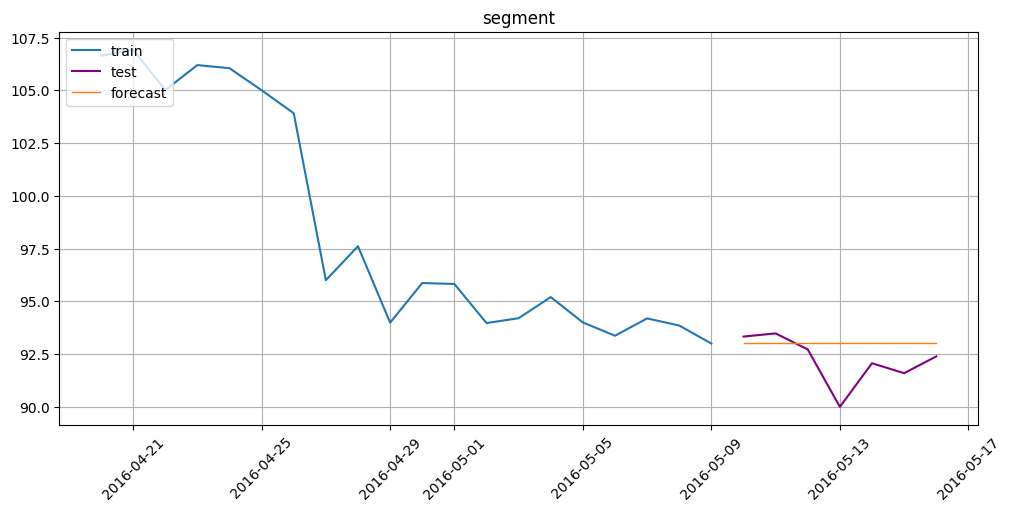

In [207]:
plot_forecast(forecast_ts_SES, test_ts, train_ts, n_train_samples=20)

In [208]:
model_H = HoltModel(
    smoothing_level=dict_params['H'][0],
    smoothing_trend=dict_params['H'][1],
    initialization_method='estimated'
).fit(train_ts)

In [209]:
future_ts_H = train_ts.make_future(HORIZON)
forecast_ts_H = model_H.forecast(future_ts_H)
smape_H = smape(y_true=test_ts, y_pred=forecast_ts_H)
print(smape_H)

{'segment': 1.1127145109427985}


In [210]:
model_results['HoltModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

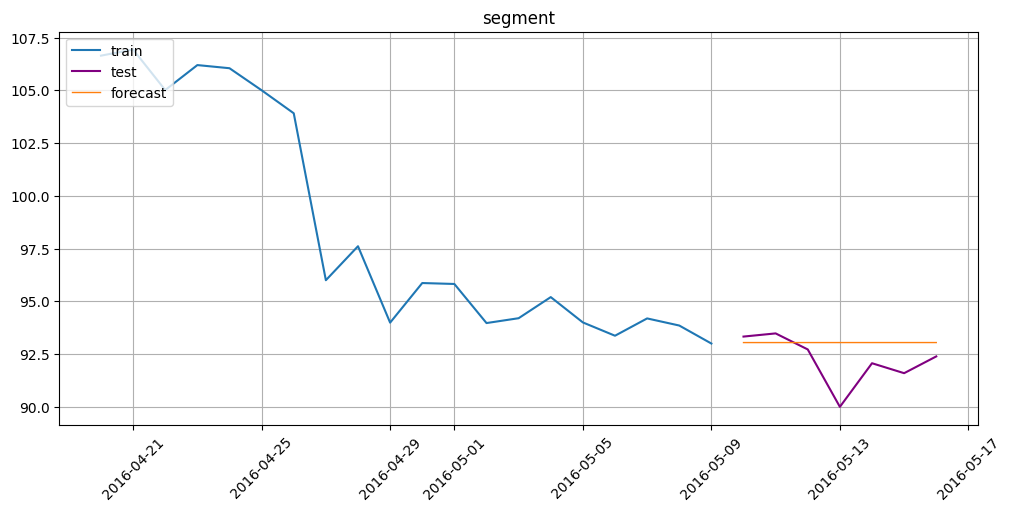

In [211]:
plot_forecast(forecast_ts_H, test_ts, train_ts, n_train_samples=20)

In [212]:
model_ES = HoltWintersModel(
    seasonal='additive',
    trend='additive',
    smoothing_level=dict_params['ES'][0],
    smoothing_trend=dict_params['ES'][1],
).fit(train_ts)

In [213]:
future_ts_ES = train_ts.make_future(HORIZON)
forecast_ts_ES = model_ES.forecast(future_ts_ES)
smape_ES = smape(y_true=test_ts, y_pred=forecast_ts_ES)
print(smape_ES)

{'segment': 1.2514675165322322}


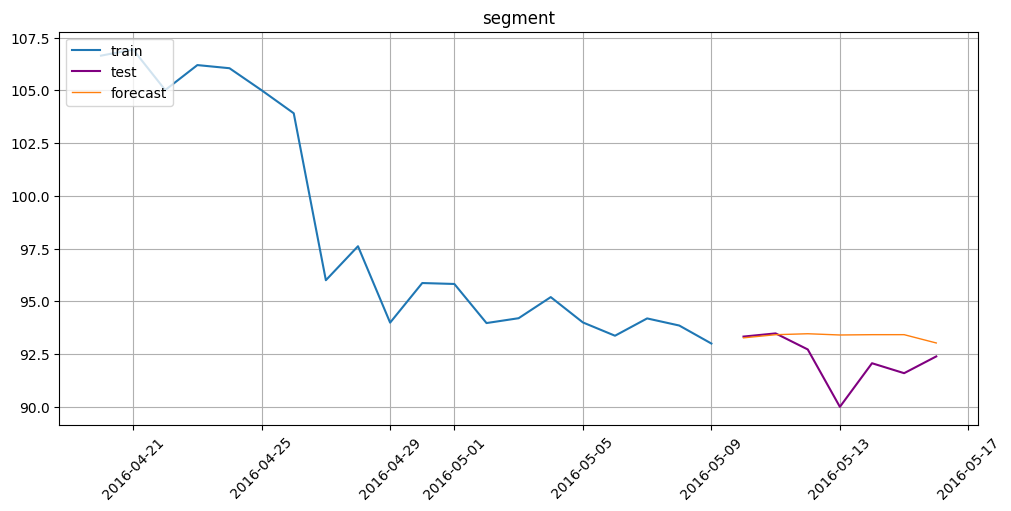

In [214]:
plot_forecast(forecast_ts_ES, test_ts, train_ts, n_train_samples=20)

In [215]:
alpha = [x / 10 for x in (range(0, 10, 2))]
beta = [x / 10 for x in (range(0, 10, 2))]
print(alpha)
parametrs = list(product(alpha, beta))
print(len(parametrs))

[0.0, 0.2, 0.4, 0.6, 0.8]
25


In [216]:
smape = SMAPE()
result = []
for param in parametrs:
    a, b = param
    model = HoltWintersModel(
        trend='additive',
        smoothing_level=a,
        smoothing_trend=b,
    ).fit(train_ts)
    future_ts = train_ts.make_future(HORIZON)
    forecast_ts = model.forecast(future_ts)
    if not(any(np.isnan(forecast_ts.to_pandas(flatten=True).target.to_list()))):
        smape_ = smape(y_true=test_ts, y_pred=forecast_ts)
        result.append((*param, smape_['segment']))

In [217]:
pd_result = pd.DataFrame(result, columns=['alpha', 'beta', 'SMAPE'])
pd_result

,alpha,beta,SMAPE
0,0.0,0.0,90.655159
1,0.0,0.2,90.655120
2,0.0,0.4,90.655152
3,0.0,0.6,90.655126
4,0.0,0.8,90.655126
5,0.2,0.0,2.697668
6,0.2,0.2,4.168052
7,0.2,0.4,1.307364
8,0.2,0.6,3.416918
9,0.2,0.8,3.697695


In [218]:
pd_new = pd_result.loc[pd_result['SMAPE'] < 15]
pd_new.sort_values('SMAPE')

,alpha,beta,SMAPE
17,0.6,0.4,0.694857
13,0.4,0.6,0.703526
18,0.6,0.6,0.894310
19,0.6,0.8,1.000349
22,0.8,0.4,1.000404
16,0.6,0.2,1.073738
12,0.4,0.4,1.150506
20,0.8,0.0,1.190815
11,0.4,0.2,1.213722
21,0.8,0.2,1.218669


{'segment': 0.6948569828398887}


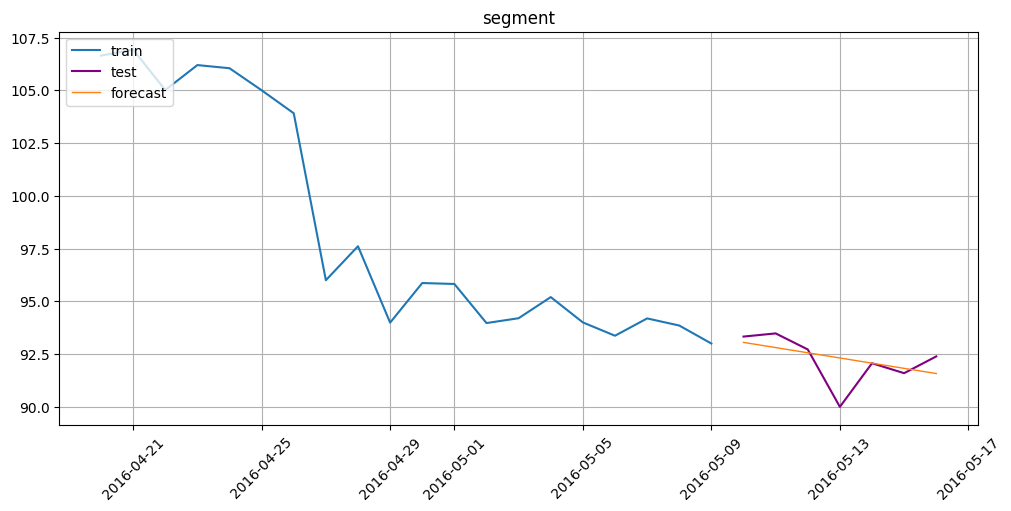

In [219]:
model = HoltWintersModel(
        trend='additive',
        smoothing_level=0.6,
        smoothing_trend=0.4,
).fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
finish_smape = smape(y_true=test_ts, y_pred=forecast_ts)
print(finish_smape)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

In [220]:
model_results['HoltWintersModel'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

# **Построение модели SARIMA**

In [221]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [222]:
D = 0
d = 1
q = range(3)
p = range(5)

parametrs = list(product(p, q))

In [252]:
results = []
best_aic = float('inf')

for param in parametrs:
    model = SARIMAX(data_df['target'],
        order = (param[0], d, param[1])).fit()
    
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param

    results.append([param, model.aic])

In [253]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

   parameters           aic
11     (3, 2)  82074.736298
8      (2, 2)  82075.716882
14     (4, 2)  82079.766726
13     (4, 1)  82082.632611
12     (4, 0)  82083.887321
9      (3, 0)  82084.066630
10     (3, 1)  82085.334742
6      (2, 0)  82087.393431
5      (1, 2)  82088.564363
2      (0, 2)  82088.567276
1      (0, 1)  82089.684526
4      (1, 1)  82090.041593
3      (1, 0)  82091.050832
7      (2, 1)  82093.605741
0      (0, 0)  82125.048057


In [254]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                12940
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -41031.368
Date:                Fri, 24 May 2024   AIC                          82074.736
Time:                        18:23:07   BIC                          82119.544
Sample:                    12-12-1980   HQIC                         82089.711
                         - 05-16-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3429      0.085     -4.052      0.000      -0.509      -0.177
ar.L2         -0.8122      0.069    -11.736      0.000      -0.948      -0.677
ar.L3         -0.0257      0.008     -3.334      0.0

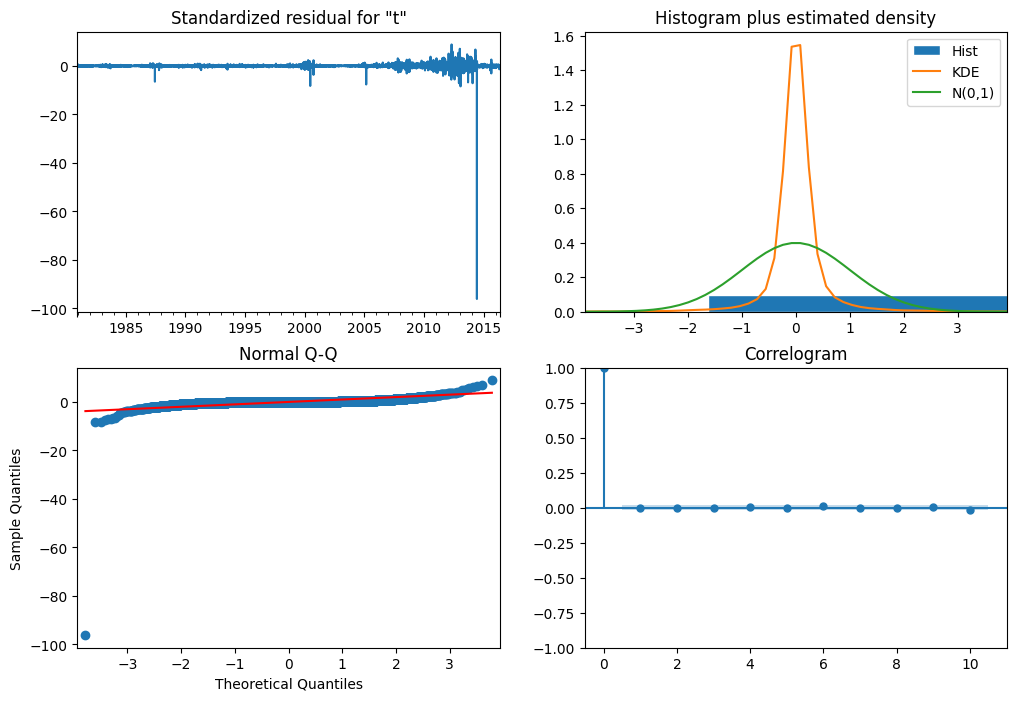

In [255]:
best_model.plot_diagnostics(figsize=(12, 8));

In [227]:
from etna.models import SARIMAXModel

In [228]:
train_ts, test_ts = data_ts.train_test_split(test_size=HORIZON)

In [229]:
model = SARIMAXModel(order=(3, 1, 1),)

model.fit(train_ts)

SARIMAXModel(order = (3, 1, 1), seasonal_order = (0, 0, 0, 0), trend = None, measurement_error = False, time_varying_regression = False, mle_regression = True, simple_differencing = False, enforce_stationarity = True, enforce_invertibility = True, hamilton_representation = False, concentrate_scale = False, trend_offset = 1, use_exact_diffuse = False, dates = None, freq = None, missing = 'none', validate_specification = True, fit_params = {}, )

In [230]:
future_ts = train_ts.make_future(HORIZON)
future_ts

segment,segment
feature,target
timestamp,
2016-05-10,NaN
2016-05-11,NaN
2016-05-12,NaN
2016-05-13,NaN
2016-05-14,NaN
2016-05-15,NaN
2016-05-16,NaN


In [231]:
forecast_ts = model.forecast(future_ts)
forecast_ts

segment,segment
feature,target
timestamp,
2016-05-10,93.065698
2016-05-11,93.074821
2016-05-12,93.053878
2016-05-13,93.051919
2016-05-14,93.051980
2016-05-15,93.051466
2016-05-16,93.051327


In [232]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment': 1.1095198156493564}

In [233]:
model_results['SARIMA'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

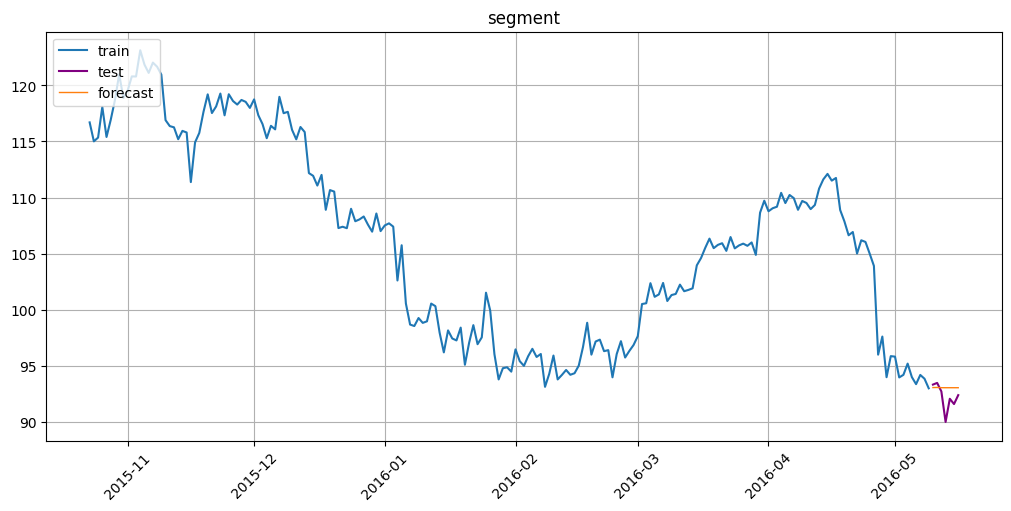

In [234]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=200)

# **Построение модели CatBoost**

In [235]:
from etna.models import CatBoostMultiSegmentModel

In [236]:
HORIZON = 7

In [237]:
train_ts, test_ts = data_ts.train_test_split(test_size=HORIZON)

In [238]:
from etna.transforms import MeanTransform, LagTransform

In [239]:
mean8 = MeanTransform(
    in_column='target',
    window=8,
    out_column='mean_8'
)
mean16 = MeanTransform(
    in_column='target',
    window=16,
    out_column='mean_16'
)

In [240]:
lags = LagTransform(
    in_column='target',
    lags=list(range(8, 15, 1)),
    out_column='lag'
)

In [241]:
train_ts.fit_transform([lags, mean8, mean16])
train_ts

segment        segment                                                  \
feature         lag_10      lag_11      lag_12      lag_13      lag_14   
timestamp                                                                
1980-12-12         NaN         NaN         NaN         NaN         NaN   
1980-12-13         NaN         NaN         NaN         NaN         NaN   
1980-12-14         NaN         NaN         NaN         NaN         NaN   
1980-12-15         NaN         NaN         NaN         NaN         NaN   
1980-12-16         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2016-05-05  105.000000  106.044445  106.193334  105.010002  106.930000   
2016-05-06  103.910004  105.000000  106.044445  106.193334  105.010002   
2016-05-07   96.000000  103.910004  105.000000  106.044445  106.193334   
2016-05-08   97.610001   96.000000  103.910004  105.000000  106.044445   
2016-05-09   93.989998   97.610001   96.000000  103.910004  105.000000   

segment                                                             
feature         lag_8       lag_9    mean_16     mean_8     target  
timestamp                                                           
1980-12-12        NaN         NaN  28.750000  28.750000  28.750000  
1980-12-13        NaN         NaN  28.750000  28.750000  28.750000  
1980-12-14        NaN         NaN  28.750000  28.750000  28.750000  
1980-12-15        NaN         NaN  28.406250  28.406250  27.375001  
1980-12-16        NaN         NaN  27.800000  27.800000  25.375000  
...               ...         ...        ...        ...        ...  
2016-05-05  96.000000  103.910004  99.774167  95.082360  94.000000  
2016-05-06  97.610001   96.000000  98.944792  94.552361  93.370003  
2016-05-07  93.989998   97.610001  98.148542  94.577361  94.190000  
2016-05-08  95.866666   93.989998  97.451250  94.325694  93.853334  
2016-05-09  95.822222   95.866666  96.626667  93.972917  93.000000  

[12933 rows x 10 columns]

In [242]:
from etna.analysis import plot_feature_relevance, ModelRelevanceTable
from sklearn.ensemble import RandomForestRegressor

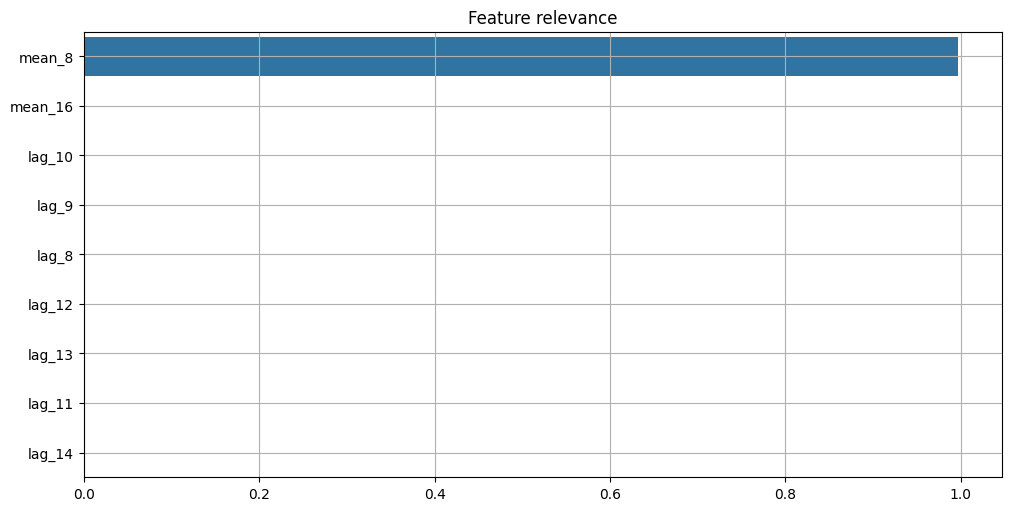

In [243]:
plot_feature_relevance(
    ts=train_ts,
    relevance_table=ModelRelevanceTable(),
    normalized=True,
    top_k=20,
    relevance_params=dict(model=RandomForestRegressor(n_estimators=100))
)

In [244]:
model = CatBoostMultiSegmentModel(loss_function='MAE',
                                  n_estimators=600,
                                  learning_rate=0.01,
                                  depth=12,
                                  random_seed=42)

In [245]:
model.fit(train_ts)

CatBoostMultiSegmentModel(iterations = None, depth = 12, learning_rate = 0.01, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, loss_function = 'MAE', n_estimators = 600, random_seed = 42, )

In [246]:
future_ts = train_ts.make_future(
    HORIZON,
    transforms=[mean8, mean16],
)
future_ts

segment       segment                  
feature       mean_16     mean_8 target
timestamp                              
2016-05-10  95.998815  93.973333    NaN
2016-05-11  95.355873  93.935556    NaN
2016-05-12  94.697863  93.682667    NaN
2016-05-13  94.589352  93.603334    NaN
2016-05-14  94.314747  93.681111    NaN
2016-05-15  94.347222  93.426667    NaN
2016-05-16  94.178395  93.000000    NaN

In [ ]:
forecast_ts = model.forecast(future_ts)

In [ ]:
forecast_ts

segment       segment                      
feature       mean_16     mean_8     target
timestamp                                  
2016-05-10  95.998815  93.973333  95.006497
2016-05-11  95.355873  93.935556  95.006497
2016-05-12  94.697863  93.682667  95.103221
2016-05-13  94.589352  93.603334  93.561281
2016-05-14  94.245159  93.630755  93.561281
2016-05-15  94.201749  93.450526  93.561281
2016-05-16  94.050393  93.316257  93.561281

In [ ]:
from etna.metrics import SMAPE

smape = SMAPE()

In [ ]:
print(smape(y_true=test_ts, y_pred=forecast_ts))

{'segment': 2.115915246574515}


In [ ]:
model_results['CatBoost'] = list(smape(y_true=test_ts, y_pred=forecast_ts).values())[0]

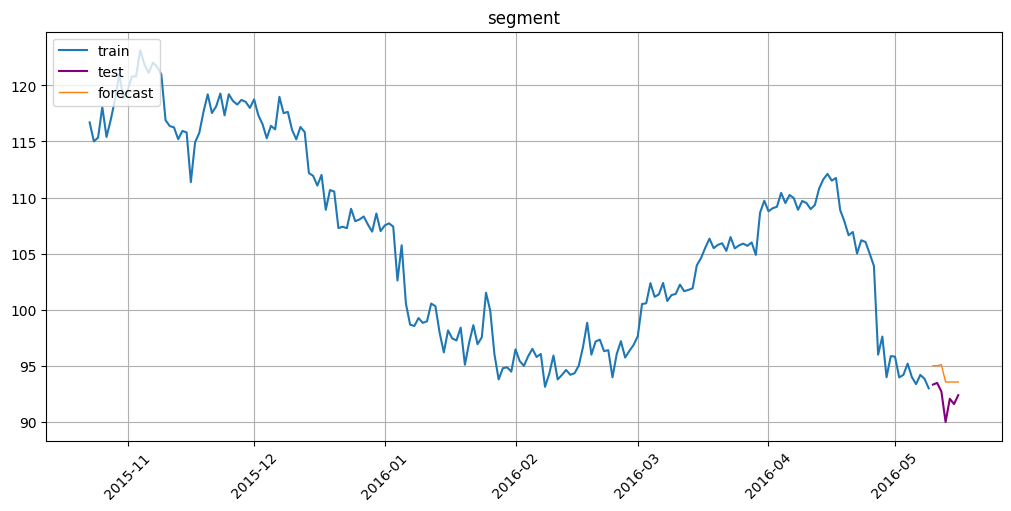

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=200)

# **Анализ построенных моделей**

In [ ]:
results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['SMAPE']).reset_index()
results_df.columns = ['Model', 'SMAPE']

In [ ]:
results_df.sort_values('SMAPE')

,Model,SMAPE
5,HoltWintersModel,0.694857
6,SARIMA,1.109520
7,CatBoost,2.115915
0,NaiveModel,2.578291
1,MovingAverageModel,9.733627
2,SeasonalMovingAverageModel,9.733627
3,SimpleExpSmoothingModel,9.733627
4,HoltModel,9.733627
